In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [35]:
data = pd.read_excel(r"C:\Users\yushi\Documents\TechJam-Toktok-Loklok\scraped_dataset_cleaned_scored.xlsx")
data.head(10)

,locationName,category,reviewerName,publishedAtDate,rating,reviewText,imageUrls,reviewerNumberOfReviews,temporarilyClosed,qualityLevel,isRelevant
0,Gardens by the Bay,Tourist attraction,Stylusmaestro,2021-12-29 10:13:13,3,For a weekday this is considered very crowded....,https://lh3.googleusercontent.com/geougc-cs/AB...,49.0,0.0,2.0,1
1,Gardens by the Bay,Tourist attraction,JoJo Chin,2020-03-21 09:06:31,5,Awsome view with breeze wind. Suitable for all...,NaN,201.0,0.0,1.0,1
2,Gardens by the Bay,Tourist attraction,Theticus _,2020-03-03 00:12:25,3,Great place to hang out and have picnic especi...,https://lh3.googleusercontent.com/geougc-cs/AB...,2181.0,0.0,1.0,1
3,Gardens by the Bay,Tourist attraction,sky wda,2020-01-02 18:05:38,5,Every years great place to catch firework on S...,https://lh3.googleusercontent.com/geougc-cs/AB...,53.0,0.0,2.0,1
4,Gardens by the Bay,Tourist attraction,Trúc Nguyễn,2020-01-01 12:22:38,5,This is the 10 times I come here. Best view,https://lh3.googleusercontent.com/geougc-cs/AB...,127.0,0.0,0.0,1
5,Gardens by the Bay,Tourist attraction,Derek Ng,2019-09-10 05:55:15,5,Marina Barrage has a nice park connector that ...,NaN,4.0,0.0,2.0,1
6,Gardens by the Bay,Tourist attraction,KJ Yaw,2019-05-15 10:23:21,5,Cannot imagine that this place was still sea a...,https://lh3.googleusercontent.com/geougc-cs/AB...,341.0,0.0,2.0,1
7,Gardens by the Bay,Tourist attraction,Abdullah Ibrahim,2019-05-02 08:21:43,3,Very nice place with a big open and spacious a...,NaN,100.0,0.0,2.0,1
8,Gardens by the Bay,Tourist attraction,Ái Việt Nguyễn,2019-03-07 03:45:04,5,"Century building, beautiful view",NaN,438.0,0.0,0.0,1
9,Gardens by the Bay,Tourist attraction,Joni Wang,2019-01-13 01:41:39,5,Good place for groups and family. It has an ou...,NaN,110.0,0.0,2.0,1


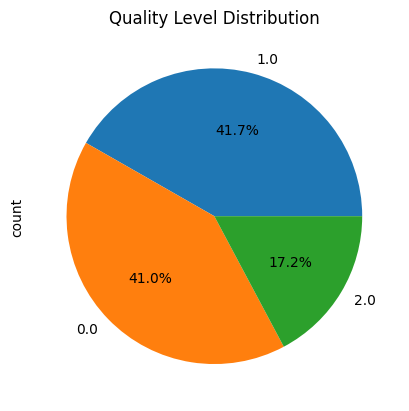

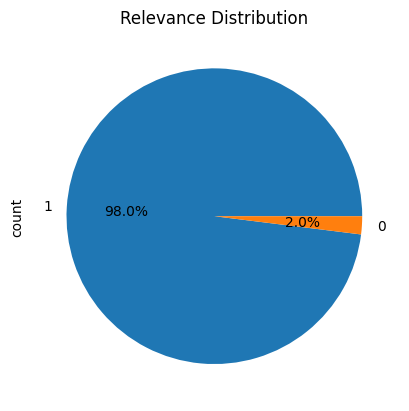

In [38]:
data["qualityLevel"].value_counts().plot(kind="pie", autopct="%1.1f%%", title="Quality Level Distribution")
plt.show()

data["isRelevant"].value_counts().plot(kind="pie", autopct="%1.1f%%", title="Relevance Distribution")
plt.show()

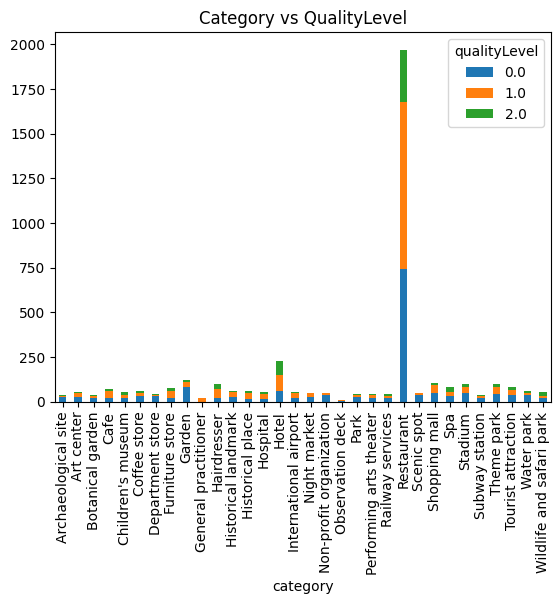

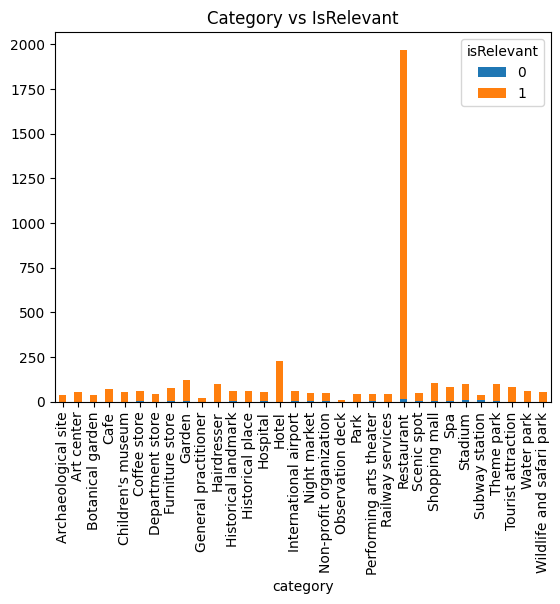

In [40]:
# category vs qualityLevel
pd.crosstab(data["category"], data["qualityLevel"]).plot(kind="bar", stacked=True)
plt.title("Category vs QualityLevel")
plt.show()

# category vs isRelevant
pd.crosstab(data["category"], data["isRelevant"]).plot(kind="bar", stacked=True)
plt.title("Category vs IsRelevant")
plt.show()

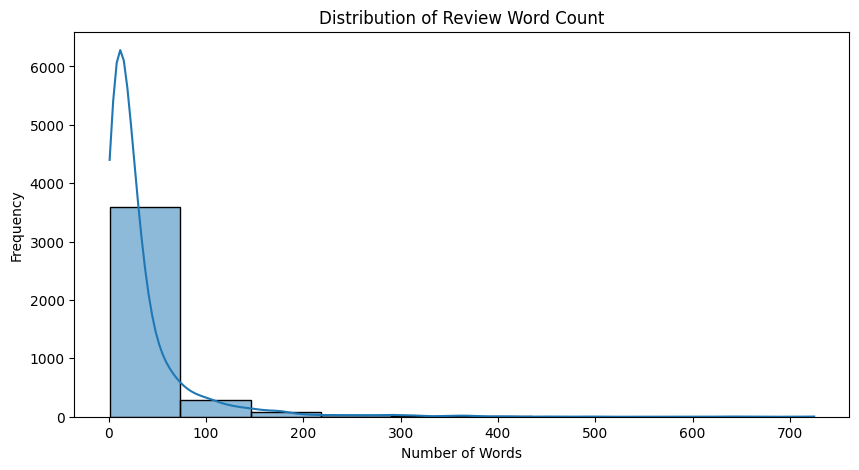

In [36]:
data["reviewWordCount"] = data["reviewText"].str.split().apply(len)
plt.figure(figsize=(10,5))
sns.histplot(data["reviewWordCount"], bins=10, kde=True)
plt.title("Distribution of Review Word Count")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

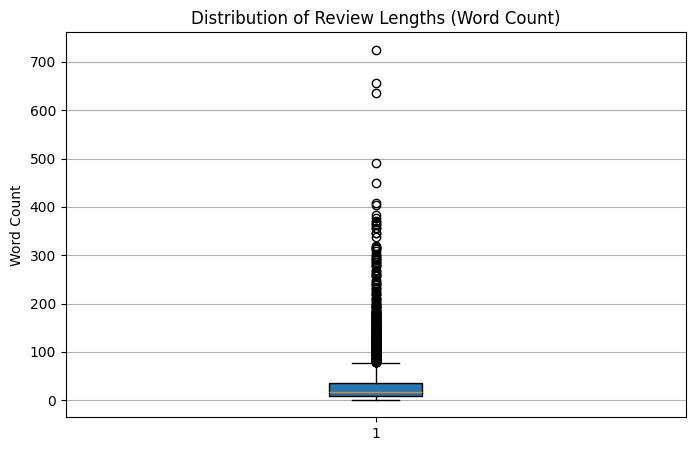

In [37]:
plt.figure(figsize=(8,5))
plt.boxplot(data["reviewWordCount"], vert=True, patch_artist=True)
plt.title("Distribution of Review Lengths (Word Count)")
plt.ylabel("Word Count")
plt.grid(axis='y')
plt.show()

In [46]:
from transformers import pipeline
import pandas as pd

# Load pretrained sentiment model
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    framework="pt"
)

# Function to map sentiment to 1–5 scale
def sentiment_to_1_5(text):
    result = sentiment_analyzer(text)[0]
    label = result['label']      # 'POSITIVE' or 'NEGATIVE'
    score = result['score']      # confidence 0–1

    # Convert to scale:
    # NEGATIVE → closer to 1, POSITIVE → closer to 5
    if label == "POSITIVE":
        mapped_score = 3 + 2 * score   # 3 to 5
    else:  # NEGATIVE
        mapped_score = 3 - 2 * score   # 1 to 3

    return mapped_score

ImportError: Traceback (most recent call last):
  File "c:\Users\yushi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
data["sentimentScore"] = data["reviewText"].apply(sentiment_to_1_5).round(2)